# 3.1. Set similarity with MinHash

## Recap

As we covered in the review, there are several different *flavours* of MinHash (e.g. KMV, Bottom-k). We will use **KMV MinHash** for now, which populates a sketch using the Minimum Values from K random permutations of the input data.

It gets a bit confusing when we start talking about k-mers as well as KMV sketches, so from now on we will only use k to refer to k-mers.

This notebook will:

* demonstrate set similarity
 - Jaccard similarity

* create the MinHash data structure using a Python library
 - add elements from a set
 - output a MinHash sketch of the set
 - estimate Jaccard similarity between sets using MinHash sketches
 
* adjust underlying properties of the MinHash data structure
 - vary the base hash function and the number of set permutations
 - compare Jaccard estimates from MinHash to the actual Jaccard set similarity

To begin, import the Python modules we will need:

In [94]:
from matplotlib_venn import venn2, venn3
from datasketch import MinHash # a MinHash library by Eric Zhu

We'll also import the functions that we covered in the [Background](Background.ipynb) workbook. This will make things like decomposing sequences to k-mers easier.

In [95]:
import nbimporter
import Background as utils

***

## A scenario

To demonstrate set similarity and MinHash for genomic data, let's use a simple scenario. We will base subsequent notebooks on this scenario and then bring it all together in the [example workflow]() for an outbreak analysis.

### Antimicrobial Resistance

**Antimicrobial resistance** (AMR) is a major public health concern and a massive research area, in which genomics plays a big role.

The term AMR refers to the ability of a microbe to resist the effects of antimicrobial drugs, which would usually kill or inactivate the microbe. Within AMR, there is antibiotic resistance, which specifically refers to bacteria that are resistant to antibiotic drugs. These resistant bacteria are harder to treat, needing higher doses or different antibiotics. Consequently, treatment regimes can be longer, more expensive or ineffective.

We will focus on antibiotic resistance and how we can use genomics and data sketching to research and combat this problem.


### Carbapenem resistance

Carbapenems are a group of antibiotic drug, belgoning to the **β-lactam** class of antibiotics. They are a very effective antibiotic and are usually reserved for treating multidrug-resistant bacterial infections.

Resistance to carbapenems is particularly worrying as there are few drugs that can treat infections caused by carbapenem resistant bacteria.

Carbapenem resistance is mediated by a particular type of enzyme that is called a **β-lactamase**. This type of enzyme can break down the structure of the antibiotic, inactivating it.

Carbapenems were typically stable against β-lactamases but this is no longer the case, with several classes of β-lactamases emerging that can break down carbapenems - these are called **carbapenemases**.


### Carbapenemases

Hopefully you are still with me - one more definition to go.... Within the carbapenemase group of enzymes, we have several classes (groan). We won't go into this really, but the important thing is that one of these classes contains **IMP-type carbapenemases** (metallo-β-lactamases).

These carbapenemase enzymes are encoded by IMP genes and, importantly, are **plasmid-mediated**. So they can be transferred between bacteria, resulting in the spread of AMR.

### TL;DR

> IMP genes confer resistance to antibiotics that are reserved for treating multi-drug resistant infections. IMP genes are mobile and contibute to the spread of antibiotic resistance.

Let's use set similarity and data sketching to look at IMP genes and see if we can differentiate between IMP genes and non-carbapenemase β-lactamases.


## Set similarity

Okay. Let's start by taking two IMP genes and seeing how similar they are, based on their k-mer composition.

* get the k-mers (k=7) for each gene:

In [96]:
# These AMR genes are downloaded from the ResFinder database (accessed 05/2017):
## blaIMP-1_1_DQ522237
geneA = "ATGAGCAAGTTATCTGTATTCTTTATATTTTTGTTTTGCAGCATTGCTACCGCAGCAGAGTCTTTGCCAGATTTAAAAATTGAAAAGCTTGATGAAGGCGTTTATGTTCATACTTCGTTTAAAGAAGTTAACGGGTGGGGCGTTGTTCCTAAACATGGTTTGGTGGTTCTTGTAAATGCTGAGGCTTACCTAATTGACACTCCATTTACGGCTAAAGATACTGAAAAGTTAGTCACTTGGTTTGTGGAGCGTGGCTATAAAATAAAAGGCAGCATTTCCTCTCATTTTCATAGCGACAGCACGGGCGGAATAGAGTGGCTTAATTCTCGATCTATCCCCACGTATGCATCTGAATTAACAAATGAACTGCTTAAAAAAGACGGTAAGGTTCAAGCCACAAATTCATTTAGCGGAGTTAACTATTGGCTAGTTAAAAATAAAATTGAAGTTTTTTATCCAGGCCCGGGACACACTCCAGATAACGTAGTGGTTTGGTTGCCTGAAAGGAAAATATTATTCGGTGGTTGTTTTATTAAACCGTACGGTTTAGGCAATTTGGGTGACGCAAATATAGAAGCTTGGCCAAAGTCCGCCAAATTATTAAAGTCCAAATATGGTAAGGCAAAACTGGTTGTTCCAAGTCACAGTGAAGTTGGAGACGCATCACTCTTGAAACTTACATTAGAGCAGGCGGTTAAAGGGTTAAACGAAAGTAAAAAACCATCAAAACCAAGCAACTAA"

## blaIMP-2_1_AJ243491
geneB = "ATGAAGAAATTATTTGTTTTATGTGTATGCTTCCTTTGTAGCATTACTGCCGCGGGAGCGCGTTTGCCTGATTTAAAAATCGAGAAGCTTGAAGAAGGTGTTTATGTTCATACATCGTTCGAAGAAGTTAACGGTTGGGGTGTTGTTTCTAAACACGGTTTGGTGGTTCTTGTAAACACTGACGCCTATCTGATTGACACTCCATTTACTGCTACAGATACTGAAAAGTTAGTCAATTGGTTTGTGGAGCGCGGCTATAAAATCAAAGGCACTATTTCCTCACATTTCCATAGCGACAGCACAGGGGGAATAGAGTGGCTTAATTCTCAATCTATTCCCACGTATGCATCTGAATTAACAAATGAACTTCTTAAAAAAGACGGTAAGGTGCAAGCTAAAAACTCATTTAGCGGAGTTAGTTATTGGCTAGTTAAAAATAAAATTGAAGTTTTTTATCCCGGCCCGGGGCACACTCAAGATAACGTAGTGGTTTGGTTACCTGAAAAGAAAATTTTATTCGGTGGTTGTTTTGTTAAACCGGACGGTCTTGGTAATTTGGGTGACGCAAATTTAGAAGCTTGGCCAAAGTCCGCCAAAATATTAATGTCTAAATATGTTAAAGCAAAACTGGTTGTTTCAAGTCATAGTGAAATTGGGGACGCATCACTCTTGAAACGTACATGGGAACAGGCTGTTAAAGGGCTAAATGAAAGTAAAAAACCATCACAGCCAAGTAACTAA"

# get the canonical k-mers for each gene
kmersA = utils.getKmers(geneA, 7)
kmersB = utils.getKmers(geneB, 7)

# sanity check and just print a few k-mers out from each gene
print(kmersA[0:10])
print(kmersB[0:10])

# how many k-mers do we have
print("blaIMP-1 is {} bases long and has {} k-mers (k=7)" .format(len(geneA), len(kmersA)))
print("blaIMP-2 is {} bases long and has {} k-mers (k=7)" .format(len(geneA), len(kmersB)))



['ATGAGCA', 'TGAGCAA', 'CTTGCTC', 'ACTTGCT', 'AACTTGC', 'CAAGTTA', 'AAGTTAT', 'AGTTATC', 'AGATAAC', 'CAGATAA']
['ATGAAGA', 'TGAAGAA', 'GAAGAAA', 'AAGAAAT', 'AATTTCT', 'GAAATTA', 'AAATTAT', 'AATAATT', 'AAATAAT', 'CAAATAA']
blaIMP-1 is 741 bases long and has 735 k-mers (k=7)
blaIMP-2 is 741 bases long and has 735 k-mers (k=7)


* now we have the two genes decomposed to sets of k-mers, let's see how similar they are

* to do this, we will calculate the Jaccard similarity:

The intersection of the k-mer sets = 299
The union of the k-mer sets = 1043

The Jaccard simularity between genes A and B = 0.286673058485139

Venn diagram showing the intersection of the carbapenemase genes:


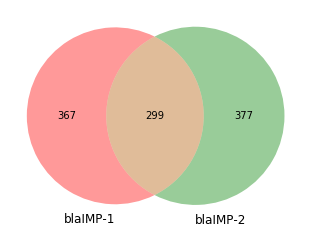

In [63]:
# this step converts the Python lists of k-mers into sets, which isn't important for the example but just let's us use some built in functions
setA = set(kmersA)
setB = set(kmersB)

# get the intersection and union of the k-mer sets
intersection = len(setA.intersection(setB))
union = len(setA.union(setB))

# calculate the Jaccard similarity
actualJaccardSimilarity = float(intersection)/float(union)

# print the values
print("The intersection of the k-mer sets = {}\nThe union of the k-mer sets = {}\n" .format(intersection, union) )
print("The Jaccard simularity between genes A and B = {}\n" .format(actualJaccardSimilarity))

# visualise with a Venn diagram
print("Venn diagram showing the intersection of the carbapenemase genes:")
venn2([setA, setB], set_labels = ('blaIMP-1', 'blaIMP-2'))

* great, so now we know that are two IMP genes share 299 k-mers and the Jaccard similarity is 0.29

* now, how does a non-carbapenemase β-lactamase gene compare?

Venn diagram showing the intersection of the β-lactamase genes:


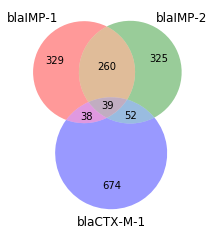

In [64]:
# CTX-M β-lactamases are also plasmid mediated but they can't break down carbapenemases
## blaCTX-M-1_6_DQ915955
geneC = "ATGGTTAAAAAATCACTGCGTCAGTTCACGCTGATGGCGACGGCAACCGTCACGCTGTTGTTAGGAAGTGTGCCGCTGTATGCGCAAACGGCGGACGTACAGCAAAAACTTGCCGAATTAGAGCGGCAGTCGGGAGGAAGACTGGGTGTGGCATTGATTAACACAGCAGATAATTCGCAAATACTTTATCGTGCTGATGAGCGCTTTGCGATGTGCAGCACCAGTAAAGTGATGGCCGTGGCCGCGGTGCTGAAGAAAAGTGAAAGCGAACCGAATCTGTTAAATCAGCGAGTTGAGATCAAAAAATCTGACTTGGTTAACTATAATCCGATTGCGGAAAAGCACGTCGATGGGACGATGTCACTGGCTGAGCTTAGCGCGGCCGCGCTACAGTACAGCGATAACGTGGCGATGAATAAGCTGATTTCTCACGTTGGCGGCCCGGCTAGCGTCACCGCGTTCGCCCGACAGCTGGGAGACGAAACGTTCCGTCTCGACCGTACCGAGCCGACGTTAAACACCGCCATTCCGGGCGATCCGCGTGATACCACTTCACCTCGGGCAATGGCGCAAACTCTGCGTAATCTGACGCTGGGTAAAGCATTGGGTGACAGCCAACGGGCGCAGCTGGTGACATGGATGAAAGGCAATACCACCGGTGCAGCGAGCATTCAGGCTGGACTGCCTGCTTCCTGGGTTGTGGGGGATAAAACCGGCAGCGGTGACTATGGCACCACCAACGATATCGCGGTGATCTGGCCAAAAGATCGTGCGCCGCTGATTCTGGTCACTTACTTCACCCAGCCTCAACCTAAGGCAGAAAGCCGTCGCGATGTATTAGCGTCGGCGGCTAAAATCGTCACCAACGGTTTGTAA"
kmersC = utils.getKmers(geneC, 7)
setC = set(kmersC)
# visualise with a Venn diagram
print("Venn diagram showing the intersection of the β-lactamase genes:")
venn3([setA, setB, setC], set_labels = ('blaIMP-1', 'blaIMP-2', 'blaCTX-M-1'))


* we can see that the blaIMP genes share a lot more k-mers than either do with the blaCTX-M gene, which was to be expected!

* now let's try approximating these similarities using MinHash

## Estimating set similarity with MinHash

We'll use a MinHash library to save us coding up the data structure. This library means we don't have to define our own hash functions (you can do if you want though). All we need to do is specify how many set permutations we want to sample from and then we just provide it the k-mers.

* create the MinHash data structure: 

In [89]:
# define the number of set permutations to apply to our k-mer sets
permutations=100

# construct a MinHash data structure for each bla-IMP gene
mh1 = MinHash(num_perm=permutations)
mh2 = MinHash(num_perm=permutations)

* now we add the k-mers from each gene to their respective MinHash:

In [90]:
# define a helper function to add set elements to a MinHash data structure
def add2MinHash(mh, data):
    # loop through the list of k-mers
    for d in data:
        # here, we use the library's update function
        # this is where each k-mer is hashed, with a different hash for each set permutation
        # if the k-mer hash is the lowest value seen to date, it is added to the MinHash sketch
        mh.update(d.encode('utf8'))
    return mh

# add the k-mers
mh1 = add2MinHash(mh1, kmersA)
mh2 = add2MinHash(mh2, kmersB)

* now we have MinHash sketches, one for each gene

* to compare the sketches and get a Jaccard similarity estimate, we just use the jaccard method from the library!

In [91]:
print("Estimated Jaccard similarity for blaIMP-1 and blaIMP-2 is", mh1.jaccard(mh2))

Estimated Jaccard similarity for blaIMP-1 and blaIMP-2 is 0.24


* not bad, our actual Jaccard similarity between blaIMP-1 and blaIMP-2 was 0.29 and our estimate is 0.24
* this estimate is based on only 100 k-mers per sketch, compared to the 735 k-mers per gene for the actual similarity
* for the sake of completeness, let's sketch the blaCTX-M gene

In [93]:
mh3 = MinHash(num_perm=permutations)
mh3 = add2MinHash(mh3, kmersC)
print("Estimated Jaccard similarity for blaIMP-1 and blaCTX-M-1 is", mh1.jaccard(mh3))
print("Estimated Jaccard similarity for blaIMP-2 and blaCTX-M-1 is", mh2.jaccard(mh3))


Estimated Jaccard similarity for blaIMP-1 and blaCTX-M-1 is 0.09
Estimated Jaccard similarity for blaIMP-2 and blaCTX-M-1 is 0.07


## MinHash a genomic data stream

So MinHash is pretty good at approximating similarity between genes. We haven't really seen the benefits though, as all we did was essential reduce the number of k-mers from 735 to 100, which doesn't save us much in terms of time or space.

Let's finish up this notebook by showing how we can apply MinHash to something more useful.

A bacteria that we look at in the example workflow is [Enterobacter cloacae](https://en.wikipedia.org/wiki/Enterobacter_cloacae), which is a nosocomial pathogen. Let's use MinHash to compare how similar the reference genome is for this bacteria to another species from the same genus, [Enterobacter mori](https://microbe.directory/species/Enterobacter+mori), which is a plant pathogen.


* let's simulate a genomic data stream from an E.cloacae download and MinHash it:

In [101]:
# stream k-mers from E. cloacae
dataStream = utils.streamGenome('../data/GCF_000025565.1_ASM2556v1_genomic.fna.gz', 7)

# set up the MinHash
cloacaeSketch = MinHash(num_perm=128)

# sketch! this will take a couple of minutes
for kmer in dataStream:
    cloacaeSketch.update(kmer.encode('utf8'))

* now do the same for E.mori:

In [102]:
# stream k-mers from E. cloacae
dataStream = utils.streamGenome('../data/GCF_000211415.1_ASM21141v1_genomic.fna.gz', 7)

# set up the MinHash
moriSketch = MinHash(num_perm=128)
for kmer in dataStream:
    moriSketch.update(kmer.encode('utf8'))

* and compare!

In [103]:
print("Estimated Jaccard similarity for E.cloacae and E.mori reference genomes is", cloacaeSketch.jaccard(moriSketch))

Estimated Jaccard similarity for E.cloacae and E.mori reference genomes is 0.9296875


So, these genomes are estimated to be 93% similar, based on k-mer composition. We have used only 128 hashes to approximate each genome, and each hash is derived from a k-mer which is 7 bases long.

A good exercise is to try the above again, this time increasing the size of k. Hopefully you should see that the longer the k, the less similar the genomes are. This is because the longer the k-mer, the more species specific it is. So, increase the k-mer length to 31 here and you should be able to differentiate between these two enterobacter species quite nicely.

You can also try changing the number of values in the sketches - long sketches give better estimates!

We'll revisit MinHash later, this time using some cool bioinformatics software which can do the above more quickly and output more information etc.

***

Return to [this notebook](./notebooks/Background.ipynb) to access the table of contents and select another notebook.

***